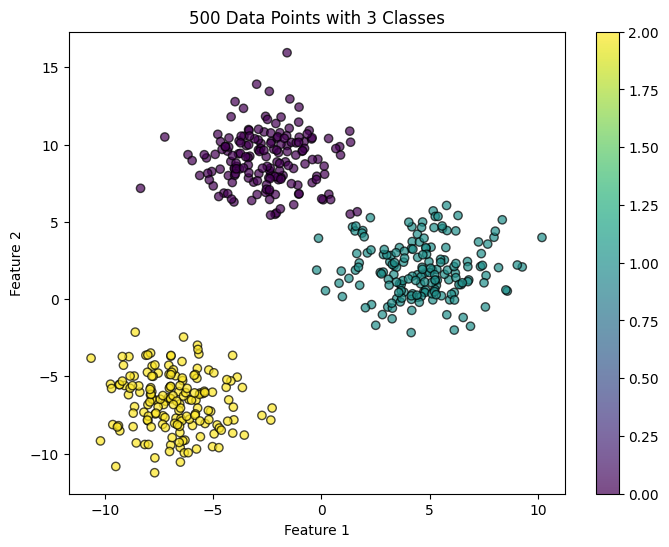

Data shape: (500, 2)
Labels shape: (500,)
Class distribution: [167 167 166]
Epoch 1: Train Loss = 0.956983, Test Loss = 0.021718, Train Acc = 0.9875, Test Acc = 1.0000
Epoch 100: Train Loss = 0.020386, Test Loss = 0.011018, Train Acc = 0.9900, Test Acc = 1.0000
Epoch 200: Train Loss = 0.018722, Test Loss = 0.009095, Train Acc = 0.9900, Test Acc = 1.0000
Epoch 300: Train Loss = 0.017503, Test Loss = 0.007975, Train Acc = 0.9925, Test Acc = 1.0000
Epoch 400: Train Loss = 0.016462, Test Loss = 0.007169, Train Acc = 0.9925, Test Acc = 1.0000
Epoch 500: Train Loss = 0.015561, Test Loss = 0.006520, Train Acc = 0.9925, Test Acc = 1.0000
Epoch 600: Train Loss = 0.014759, Test Loss = 0.005926, Train Acc = 0.9925, Test Acc = 1.0000
Epoch 700: Train Loss = 0.014031, Test Loss = 0.005414, Train Acc = 0.9925, Test Acc = 1.0000
Epoch 800: Train Loss = 0.013328, Test Loss = 0.004974, Train Acc = 0.9925, Test Acc = 1.0000
Epoch 900: Train Loss = 0.012682, Test Loss = 0.004585, Train Acc = 0.9925, Test

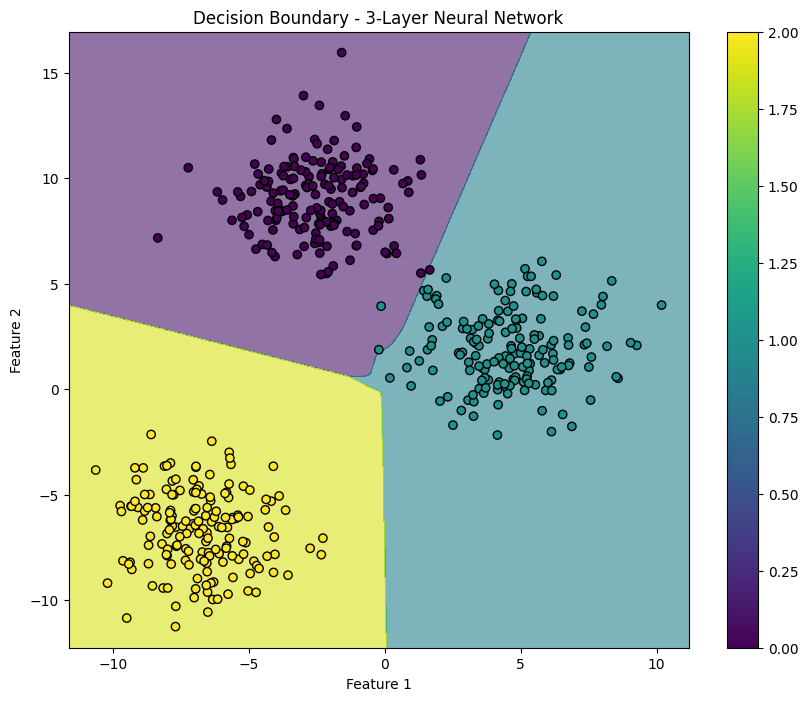

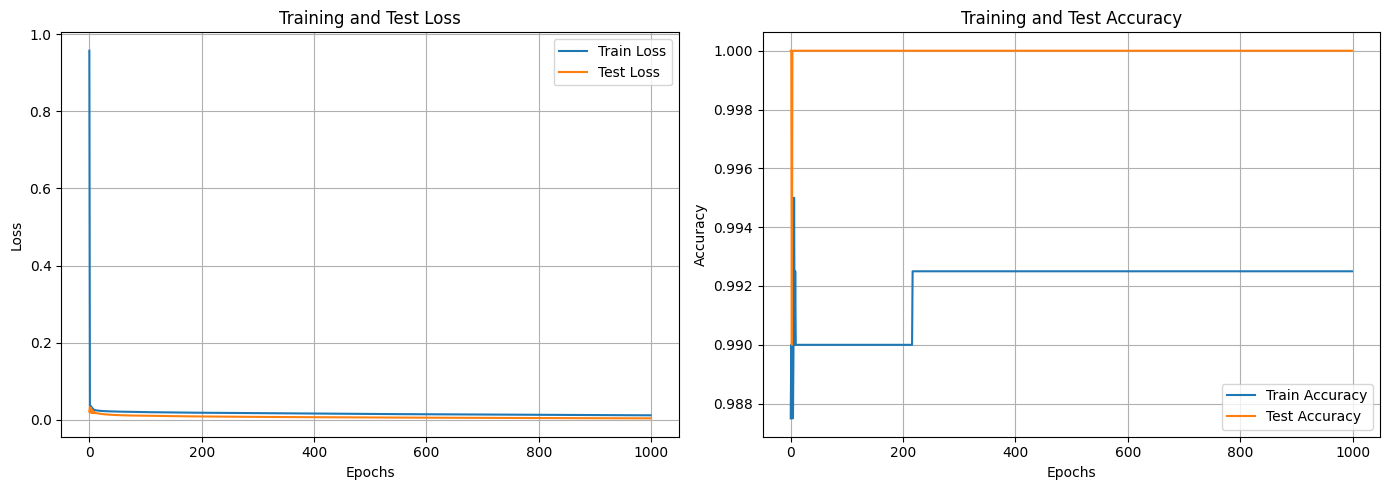

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# -----------------------------
# TUNABLE VARIABLES (change these)
# -----------------------------
N = 500
centers = 3
n_features = 2
cluster_std = 1.8
random_state = 42

hidden1_size = 64
hidden2_size = 32
learning_rate = 0.1
epochs = 1000
test_size = 0.2
# -----------------------------

# Generate data
X, y = make_blobs(n_samples=N, centers=centers, n_features=n_features,
                  cluster_std=cluster_std, random_state=random_state)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolors='k')
plt.colorbar(scatter)
plt.title(f'{N} Data Points with {centers} Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# -----------------------------
# Neural network implementation
# -----------------------------
class ThreeLayerNN:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, learning_rate=0.1, seed=42):
        np.random.seed(seed)
        self.learning_rate = learning_rate
        # He / small initialization
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden1_size))
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2.0 / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        self.W3 = np.random.randn(hidden2_size, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, z):
        # z = pre-activation (correct)
        return (z > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        # store pre-activations (z) and activations (a) for backprop
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        return self.a3

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        y_true_onehot = np.eye(y_pred.shape[1])[y_true]
        loss = -np.sum(y_true_onehot * np.log(y_pred + 1e-12)) / m
        return loss

    def backward(self, X, y):
        m = X.shape[0]
        y_true_onehot = np.eye(self.W3.shape[1])[y]

        # output layer
        dz3 = (self.a3 - y_true_onehot)  # (m, C)
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        # layer 2
        dz2 = np.dot(dz3, self.W3.T) * self.relu_derivative(self.z2)  # use z2 (pre-activation)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # layer 1
        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)  # use z1 (pre-activation)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        return dW1, db1, dW2, db2, dW3, db3

    def update_parameters(self, dW1, db1, dW2, db2, dW3, db3):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

# -----------------------------
# Train / Evaluate
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

input_size = X_train.shape[1]
output_size = centers

model = ThreeLayerNN(input_size, hidden1_size, hidden2_size, output_size, learning_rate=learning_rate, seed=random_state)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    # Forward on train
    train_probs = model.forward(X_train)
    train_loss = model.compute_loss(train_probs, y_train)

    # Backprop and update
    dW1, db1, dW2, db2, dW3, db3 = model.backward(X_train, y_train)
    model.update_parameters(dW1, db1, dW2, db2, dW3, db3)

    # Metrics
    train_accuracy = model.accuracy(X_train, y_train)
    test_probs = model.forward(X_test)
    test_loss = model.compute_loss(test_probs, y_test)
    test_accuracy = model.accuracy(X_test, y_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}, "
              f"Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}")

# Final results
final_train_acc = model.accuracy(X_train, y_train)
final_test_acc = model.accuracy(X_test, y_test)
print("\nFinal Results:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Test Accuracy: {final_test_acc:.4f}")
print(f"Training Loss: {train_losses[-1]:.6f}")
print(f"Test Loss: {test_losses[-1]:.6f}")

# -----------------------------
# Decision boundary (visual)
# -----------------------------
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black', cmap='viridis')
plt.colorbar(scatter)
plt.title('Decision Boundary - 3-Layer Neural Network')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# -----------------------------
# Loss & Accuracy plots
# -----------------------------
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
